# Project Idea

## Introduction
- An airline company wants to have a model that is highly effective at predicting passenger satisfaction and determines which factors has more impact of the passenger satisfaction. 

## Step 1: Import Packages and Load Data

In [1]:
# Import relevant libraries and modules
import numpy as np
import pandas as pd
import matplotlib as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import XGBClassifier
from xgboost import plot_importance

In [7]:
# Load the dataset
airline_data = pd.read_csv('Invistico_Airline.csv', on_bad_lines='skip')

# Display the first few rows of data
airline_data.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


## Step 2: Model Preparation
- The **satisfaction** variable represents the classification feature to be predicted.
- Rest of the features seem like meaningful predictors of satisfaction. In particular, **delays (either departure or arrival)** may be negatively correlated with satisfaction.
- As this is a binary classfication problem, it will be important to evaluate not just `accuracy` score, but the balance of false positives and false negatives that the model's predictions provide. Therefore, `precision`, `recall`, and `F1` scores will be excellent metrics to use.
- The `ROC` and `AUC` (Area Under the Receiver Operating Characteristic) scores are also suited to this type of modeling.

In [8]:
# Encode the object predictors to numerical
airline_data_dummies = pd.get_dummies(airline_data, columns=['satisfaction','Customer Type','Type of Travel','Class'])

### Split the Data into Training and Testing

In [9]:
# Define the y (target) feature
y = airline_data_dummies['satisfaction_satisfied']

# Define the X (predictor) features
X = airline_data_dummies.drop(['satisfaction_satisfied','satisfaction_dissatisfied'], axis = 1)

In [10]:
# Perform the split operation on your data with a ratio of 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Step 3: Model Building

In [11]:
# Instantiate XGBClassifier model
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Define parameters for tuning as `cv_params`
cv_params = {'max_depth': [4, 6],
             'min_child_weight': [3, 5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [5,10,15],
             'subsample': [0.7],
             'colsample_bytree': [0.7]
            }

# Define `scoring` metrics
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Construct the GridSearch.
xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 5, refit = 'f1')

In [12]:
# Fit the GridSearch model to the training data
%time

xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1', scoring={'f1', 'precision', 'recall', 'accuracy'})

In [13]:
# Use `pickle` to save the trained model
pickle.dump(xgb_cv, open('xgb_cv.sav', 'wb'))

## Step 4: Results and Evaluation

In [14]:
# Apply the model to predict on the test data
y_pred = xgb_cv.predict(X_test)

In [15]:
# Leverage metrics to evaluate the model's performance

ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.9296889436402833
precision score: 0.9413165504337473
recall score: 0.9300840336134454
f1 score: 0.9356665821286668


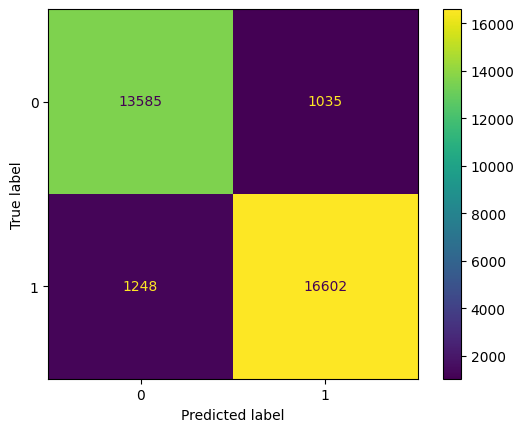

In [16]:
# Construct the confusion matrix for the predicted and test values.
cm = metrics.confusion_matrix(y_test, y_pred)

# Create the display for the confusion matrix.
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)

# Plot the visual in-line.
disp.plot()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

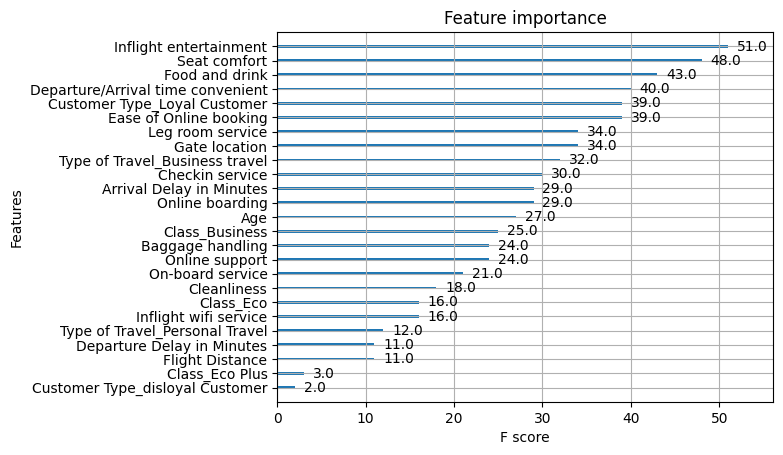

In [17]:
# Visualize the relative feature importance of the predictor variables in your model.
plot_importance(xgb_cv.best_estimator_)

**Insight:**
- By a wide margin, `seat comfort` rated as most important in the model.The type of seating is very different between first class and coach seating. However, the perks of being in first class also go beyond the seating type, so perhaps that is an underlying explanation of this feature's importance.
- Surprisingly, `delays (both arrival and departure)` did not score as highly important.

## Executive Summary
- The model created is highly effective at predicting passenger satisfaction.
- The feature importance of seat comfort warrants additional investigation. It will be important to ask domain experts why they believe this feature scores so highly in this model.